In [1]:
from lensingbiases._lensing_biases import lensingbiases as bias

In [2]:
#first we need ClTT
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [6]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


/home/users/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/home/users/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [9]:
ell = list([i for i in lRange])

In [10]:
lRange[1]

7000.0

In [64]:
l_dat = np.loadtxt('n1_data/test_data_set_lenspotentialCls.dat').T[0]
TP = np.loadtxt('n1_data/test_data_set_lenspotentialCls.dat').T[-2]
fTP = interp1d(l_dat, TP, kind='linear', bounds_error=False, fill_value=0.)

(37, 175)
(6, 6, 175)


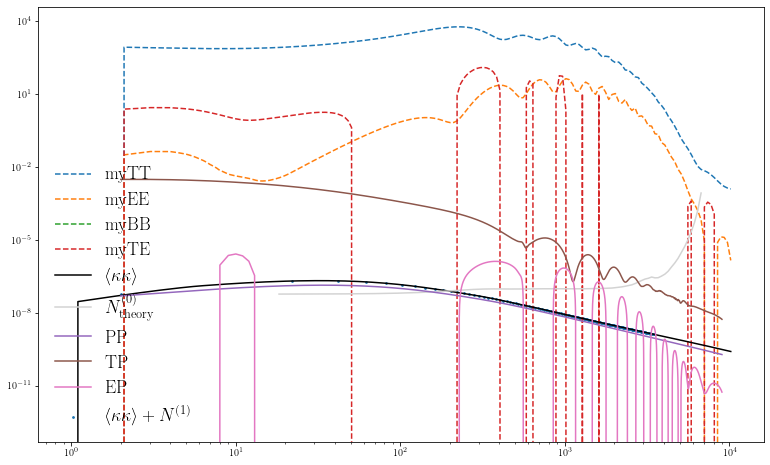

In [123]:
plt.figure(figsize=(13,8))


ell = baseMap.l.flatten()
theory=[cmb.funlensedTT, cmb.funlensedEE, cmb.funlensedBB,  cmb.funlensedTE]
theory_l=[r'myTT', r'myEE', r'myBB', r'myTE']
for f,l in zip(theory, theory_l):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    plt.plot(L, (L*L+1)/(2*np.pi)*ClExpected, '--', label=l)


ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    plt.plot(L, ClExpected, sty, label=l)


labels = ['TT', 'EE', 'BB', 'TE','PP','TP','EP']
for tmp in [
            'n1_data/test_data_set_lenspotentialCls.dat',  #unlensed TT
#             'n1_data/N1_All_analytical.dat', 
#             'n1_data/N0_analytical.dat',
#             'n1_data/test_data_set_lensedCls.dat' #lsendTT
]:
    asdf = np.loadtxt(tmp).T
    l_dat = asdf[0]
    for i in range(len(asdf)-1):
        if(labels[i] not in ['PP', 'TP', 'EP']):
            continue
        phiphi = asdf[i+1]
        plt.plot(l_dat, phiphi, label=labels[i])

        
for tmp in [
#             'n1_data/test_data_set_lenspotentialCls.dat',  #unlensed TT
            'n1_data/N1_All_analytical.dat', 
#             'n1_data/N0_analytical.dat',
#             'n1_data/test_data_set_lensedCls.dat' #lsendTT
]:
    n1 = np.loadtxt(tmp).T    
    indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
    bins = n1[0]
    print(np.shape(n1))
    n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
    print(np.shape(n1_mat))
    for i in range(len(indices)):
        if(indices[i] != 'TT'):
            continue
#         plt.plot(bins, (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:]), label=indices[i])
#         plt.scatter(bins, (bins*(bins+1))**2/(2*np.pi)*(-n1_mat[i][i][:]), label=indices[i])
        
        ClExpected = np.array(list(map(p2d_cmblens.fPinterp, bins)))
        asdf = (bins*(bins+1))/(2*np.pi)*ClExpected+(bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
        asdf = asdf*2*np.pi/(bins*(bins+1))
        plt.scatter(bins, asdf, s=3, label=r'$\big<\kappa\kappa\big>+N^{(1)}$')


#     for i in range(3):
#         phiphi = asdf[i+1]
#         plt.plot(l_dat, phiphi, label='N1 col%d'%i)
plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')

(38, 175)


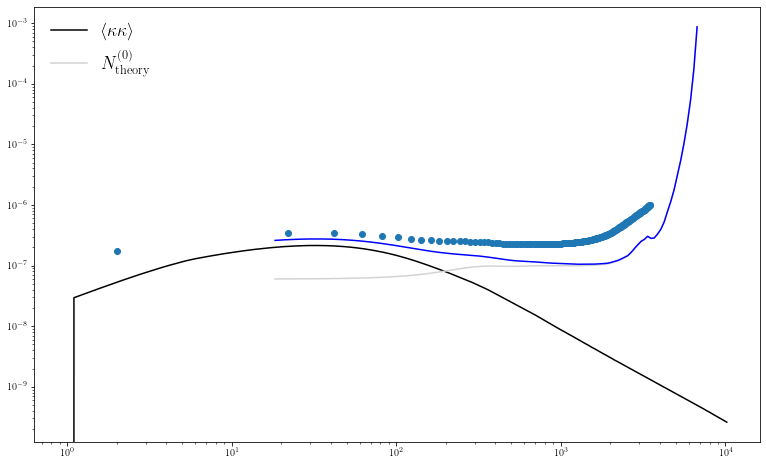

In [128]:
plt.figure(figsize=(13,8))


# ell = baseMap.l.flatten()
# theory=[cmb.funlensedTT, cmb.funlensedEE, cmb.funlensedBB,  cmb.funlensedTE]
# theory_l=[r'myTT', r'myEE', r'myBB', r'myTE']
# for f,l in zip(theory, theory_l):
#     L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
#     ClExpected = np.array(list(map(f, L)))
#     plt.plot(L, (L*L+1)/(2*np.pi)*ClExpected, '--', label=l)


ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    plt.plot(L, ClExpected, sty, label=l)

L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
ClExpected = np.array(list(map(p2d_cmblens.fPinterp, L))) + np.array(list(map(Ntheory, L)))
plt.plot(L, ClExpected, 'blue')#, label=l)
    

# labels = ['TT', 'EE', 'BB', 'TE','PP','TP','EP']
# for tmp in [
#             'n1_data/test_data_set_lenspotentialCls.dat',  #unlensed TT
# #             'n1_data/N1_All_analytical.dat', 
# #             'n1_data/N0_analytical.dat',
# #             'n1_data/test_data_set_lensedCls.dat' #lsendTT
# ]:
#     asdf = np.loadtxt(tmp).T
#     l_dat = asdf[0]
#     for i in range(len(asdf)-1):
#         if(labels[i] not in ['PP', 'TP', 'EP']):
#             continue
#         phiphi = asdf[i+1]
#         plt.plot(l_dat, phiphi, label=labels[i])

        
for tmp in [
#             'n1_data/test_data_set_lenspotentialCls.dat',  #unlensed TT
#             'n1_data/N1_All_analytical.dat', 
            'n1_data/N0_analytical.dat',
#             'n1_data/test_data_set_lensedCls.dat' #lsendTT
]:
    n0 = np.loadtxt(tmp).T
    print(np.shape(n0))
    indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
    bins = n0[0]
    phiphi = n0[1]
    n0_mat = np.reshape(n0[2:], (len(indices), len(indices), len(bins)))
    
    for i in range(len(indices)):
        if(indices[i] != 'TT'):
            continue
        n0_pp  = (bins*(bins+1))**2/(2*np.pi)*(n0_mat[i][i][:])
        
        KK = p2d_cmblens.fPinterp(bins)
        
        phiphi =  -2. * KK / bins**2
        phiphi *=  -2./ bins**2
        phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 
        
        pp_n0 = phiphi+n0_pp
        
        KK_n0 = pp_n0 * 2*np.pi / (bins*(bins+1))**2
        KK_n0 *= - bins**2 / 2
        KK_n0 *= - bins**2 / 2
        plt.scatter(bins, KK_n0)#, label=indices[i])
        
#         ClExpected = np.array(list(map(p2d_cmblens.fPinterp, bins)))
#         asdf = (bins*(bins+1))/(2*np.pi)*ClExpected+(bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
#         asdf = asdf*2*np.pi/(bins*(bins+1))
#         plt.scatter(bins, asdf, s=3, label=r'$\big<\kappa\kappa\big>+N^{(1)}$')


#     for i in range(3):
#         phiphi = asdf[i+1]
#         plt.plot(l_dat, phiphi, label='N1 col%d'%i)
plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')

(37, 175)
(6, 6, 175)


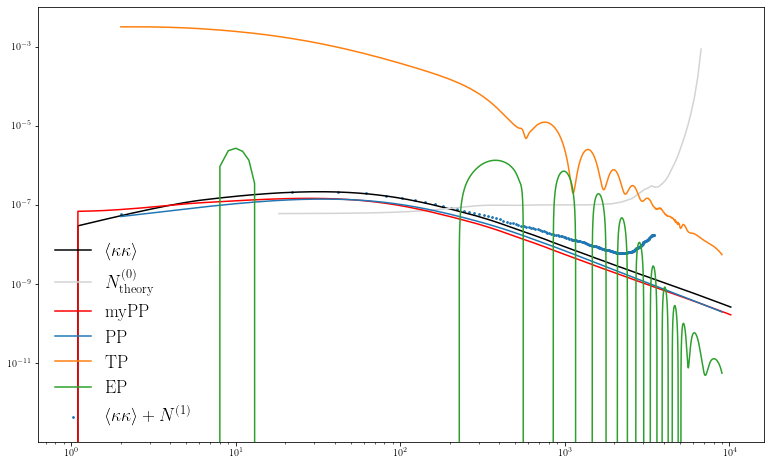

In [130]:
plt.figure(figsize=(13,8))




ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    plt.plot(L, ClExpected, sty, label=l)

ell = baseMap.l.flatten()
L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
ClExpected = np.array(list(map(p2d_cmblens.fPinterp, L)))
phiphi =  -2. * ClExpected / L**2
phiphi =  -2. * phiphi / L**2
phiphi = (L*(L+1))**2/(2*np.pi)* phiphi #convention from CAMB
plt.plot(L, phiphi, 'red', label='myPP')

labels = ['TT', 'EE', 'BB', 'TE','PP','TP','EP']
for tmp in [
            'n1_data/test_data_set_lenspotentialCls.dat',  #unlensed TT
#             'n1_data/N1_All_analytical.dat', 
#             'n1_data/N0_analytical.dat',
#             'n1_data/test_data_set_lensedCls.dat' #lsendTT
]:
    asdf = np.loadtxt(tmp).T
    l_dat = asdf[0]
    for i in range(len(asdf)-1):
        if(labels[i] not in ['PP', 'TP', 'EP']):
            continue
        phiphi = asdf[i+1]
        plt.plot(l_dat, phiphi, label=labels[i])

        
for tmp in [
#             'n1_data/test_data_set_lenspotentialCls.dat',  #unlensed TT
            'n1_data/N1_All_analytical.dat', 
#             'n1_data/N0_analytical.dat',
#             'n1_data/test_data_set_lensedCls.dat' #lsendTT
]:
    n1 = np.loadtxt(tmp).T    
    indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
    bins = n1[0]
    print(np.shape(n1))
    n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
    print(np.shape(n1_mat))
    for i in range(len(indices)):
        if(indices[i] != 'TT'):
            continue
#         plt.plot(bins, (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:]), label=indices[i])
#         plt.scatter(bins, (bins*(bins+1))**2/(2*np.pi)*(-n1_mat[i][i][:]), label=indices[i])
        
        n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
        KK = p2d_cmblens.fPinterp(bins)
        
        phiphi =  -2. * KK / bins**2
        phiphi *=  -2./ bins**2
        phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 
        
        pp_n1 = phiphi+n1_pp
        
        KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2
        KK_n1 *= - bins**2 / 2
        KK_n1 *= - bins**2 / 2
        plt.scatter(bins, KK_n1, s=3, label=r'$\big<\kappa\kappa\big>+N^{(1)}$')


#     for i in range(3):
#         phiphi = asdf[i+1]
#         plt.plot(l_dat, phiphi, label='N1 col%d'%i)
plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')